# Section 1

## Efstathios Galanakis 03112172
## Ioannis Tzanettis 03112506
## Team Number: ???


Datasheet Name: Sonar (Number S3)
Number of features: 60
Number of classes: 2 (Mine, Rock)


# Insert Dataset
This datasheet contains data taken from a sonar signal.

Taking into account the file sonar.name, which gives us information about the datasheet, there aren't any
headers or numbering so when we use the read__csv command, we will add the option header=None. The label of
each samples is placed at the last column

We use, as we previously said, the command read_csv in order to read the datasheet from the file
sonar.all-data. No changes to the file or the datasheet need to be done.

The file sonar.names doesn't refer to any missing data so we supposed that there aren't. It says that 
every feature's value range is between 0.0 and 1.0.

We need to convert labels string values to int values so we are going to create the following mapping:
mapping = {'R' : 0, 'M' : 1}

We have to check if the sample data are unbalanced in case they aren't, to resample them.

In [264]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

features = []
labels = []


datasheet_path='./small/sonar.all-data'
datasheet = pd.read_csv(datasheet_path, header=None)

labels = datasheet.iloc[:, [-1]]
features = datasheet.iloc[:, 0 :-1].values

mapping = {'R' : 0, 'M' : 1}
labels = labels.replace(mapping).values.flatten()
print datasheet.shape
print features.shape, labels.shape

# check labels freqs
label_freq = np.bincount(labels)/np.float64(labels.size)
max_rate = np.max(label_freq)

ros = RandomOverSampler(random_state=0)

if (max_rate > 0.6):
    print "resampling..."
    features, labels = ros.fit_sample(features,labels)

print max_rate


(208, 61)
(208, 60) (208,)
0.533653846154


Test data arne 20% of the total data and the rest is train data
So we seperate them

In [273]:
perc = 0.2

x_train, x_test, y_train, y_test = train_test_split(features,labels,test_size=perc)

print  features.shape, labels.shape
print x_train.shape, x_test.shape, y_train.shape, y_test.shape


(208, 60) (208,)
(166, 60) (42, 60) (166,) (42,)


# Baseline classification
After spliting data, it's time to create dummy classifiers and MLP classifier with
default parameters, in order to compare with their improved versions. For constant strategy
we will predict as M every state which means we have a Mine there.

In [291]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

state = 1
dummy_strategies = [ 'stratified', 'most_frequent', 'prior', 'uniform', 'constant']
conf = []
macro = []
weighted = []
precision = []
recall = []
# dummy_classifiers= {}
for i in dummy_strategies:
    if (i == 'constant'):
       dummy_classifiers=DummyClassifier(strategy=i, constant=state)
    else:
        dummy_classifiers=DummyClassifier(strategy=i)

    dummy_classifiers.fit(x_train,y_train)
    results = dummy_classifiers.predict(x_test)
    conf.append( confusion_matrix(y_test, results))
    macro += [f1_score(y_test, results, average='macro')]
    weighted.append(  f1_score(y_test, results, average='weighted'))
    precision.append( precision_score(y_test, results))
    recall.append(  recall_score(y_test, results))
    print dummy_classifiers.strategy, ":", accuracy_score(results,y_test)
    
default_clf_Mlp = MLPClassifier();
default_clf_Mlp.fit(x_train, y_train)
results = default_clf_Mlp.predict(x_test)
conf.append( confusion_matrix(y_test, results))
macro.append( f1_score(y_test, results, average='macro'))
weighted.append(f1_score(y_test, results, average='weighted'))
precision.append(  precision_score(y_test, results))
recall.append(recall_score(y_test, results))
print "default_clf_Mlp :",accuracy_score(results,y_test)
print conf[0]

stratified : 0.642857142857
most_frequent : 0.595238095238
prior : 0.595238095238
uniform : 0.547619047619
constant : 0.595238095238


default_clf_Mlp : 0.785714285714
[[ 9  8]
 [ 7 18]]


Time to plot our metrics

['stratified', 'most_frequent', 'prior', 'uniform', 'constant', 'MLP']


<Container object of 6 artists>

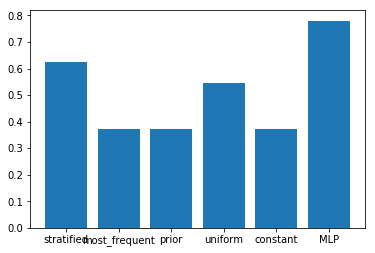

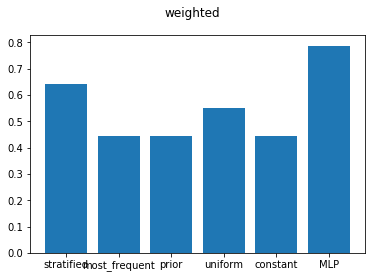

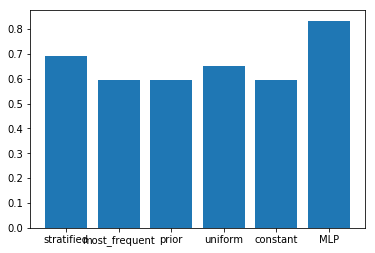

In [294]:
import matplotlib.pyplot as plt
clf_names = dummy_strategies + ['MLP']
print clf_names
fig = 1
plt.figure(fig)
plt.suptitle('f1_macro')
plt.bar(range(len(macro)),macro,tick_label=clf_names)

fig +=1
plt.figure(fig)
plt.suptitle('f1_weighted')
plt.bar(range(len(weighted)),weighted,tick_label=clf_names)

fig +=1
plt.figure(fig)
plt.suptitle('precision')
plt.bar(range(len(precision)),precision,tick_label=clf_names)

fig +=1
plt.figure(fig)
plt.suptitle('recall')
plt.bar(range(len(recall)),recall,tick_label=clf_names)


## Feature selection
Now it's time to create our improved MLP classifier. First we create a VarianceThreshold selector with threshold 5%
in order to reduces the number of features. Then we usa a mask (selected_features) in order to keep the selected features

In [186]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(0.0001)
reduced_train_data = selector.fit_transform(x_train)

print reduced_train_data.shape

selected_features = selector.get_support()
reduced_test_data = x_test[:,selected_features]

print reduced_test_data.shape

(166, 51)
(42, 51)


## Scaling features
We need to scale our data, in order to take values in the range [-1, 1]. So we need to
check if exist any value bigger than 1.0 or smaller than -1. If there is no such value, no scalling
is needed.

In [187]:
from sklearn.preprocessing import StandardScaler

max_timi =  np.max(reduced_train_data)
min_timi =  np.min(reduced_train_data)


if (max_timi > np.float64(1.0) or  ( min_timi < np.float64(-1.0))):
    scaler = StandardScaler()
    scaled_train_data = scaler.fit_transform(reduced_train_data)
    scaled_test_data =  scaler.fit_transform(reduced_test_data)
else:
    print "No Scalling needed"
    scaled_train_data = reduced_train_data
    scaled_test_data = reduced_test_data
print scaled_train_data.shape


No Scalling needed
(166, 51)


## Resampling
We need to examine if our dataset is balanced, which means that there is no label, whose rate through the dataset
is 1.5 times more frequent than the rest labels.

In [188]:
from imblearn.over_sampling import RandomOverSampler

label_freq = np.bincount(y_train)/np.float64(y_train.size)
max_rate = np.max(label_freq)

ros = RandomOverSampler(random_state=0)

if (max_rate > 0.6):
    print "resampling..."
    scaled_train_data, y_train = ros.fit_sample(scaled_train_data,y_train)

print max_rate

0.530120481928


## Cross Validation

After data preprocessing, it's time to select the suitable MLP Classifier. We will break our train set into 10 sets
and we are going to use 2 metrics: f1_macro and f1_weighted, so we need to make a new scorer which sets the final
score as the sum of the previous metrics' score

In [189]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

def my_scorer(estimator, x, y):
    prediction = estimator.predict(x)
    macro_score = f1_score(y, prediction, average='macro')
    weighted_score = f1_score(y, prediction, average='weighted')
    return macro_score + weighted_score
    
k = 10
scoring_policy = ['f1_macro', 'f1_weighted']


Now it's time to estimate MLP Classifier parameters, using cross validation.
First we have to find the best solve.

In [166]:

solver_opts = ['lbfgs', 'sgd', 'adam']

f_score=[]
leksiko={}
for i in range(0,len(solver_opts)):
    print solver_opts[i]
    clf = MLPClassifier(solver=solver_opts[i])
    clf.fit(scaled_train_data,y_train)              
    val_scores=cross_val_score(clf,x_train,y_train,cv=k,scoring= my_scorer)
    f_score.append( np.mean(val_scores))
    leksiko[solver_opts[i]] = np.mean(val_scores)

f_solver = solver_opts[np.argmax(f_score)]
print f_solver
print f_score
print np.max(f_score)
print leksiko


lbfgs
sgd
adam
lbfgs
[1.5371848692243428, 1.0698929037938325, 1.4994802995422192]
1.53718486922
{'adam': 1.4994802995422192, 'sgd': 1.0698929037938325, 'lbfgs': 1.5371848692243428}


Then we have to find the right alpha value.

In [167]:
alpha_opt =  np.logspace(-5, 3, 5)

f_score=[]
leksiko={}
for i in range(0,alpha_opt.size):
    print alpha_opt[i]
    clf = MLPClassifier(solver=f_solver,alpha=alpha_opt[i])
    clf.fit(scaled_train_data,y_train)
    val_scores=cross_val_score(clf,scaled_train_data,y_train,cv=k,scoring= my_scorer)
    f_score.append( np.mean(val_scores))
    leksiko[alpha_opt[i]] = np.mean(val_scores)

f_alpha = alpha_opt[np.argmax(f_score)]
print f_alpha
print f_score
print np.max(f_score)

print leksiko


5
1e-05
0.001
0.1
10.0
1000.0
0.1
[1.5703398532152402, 1.5660143086187976, 1.6302422723475356, 1.3172417228454381, 0.70408616958489101]
1.63024227235
{1000.0: 0.70408616958489101, 0.001: 1.5660143086187976, 1.0000000000000001e-05: 1.5703398532152402, 10.0: 1.3172417228454381, 0.10000000000000001: 1.6302422723475356}


Now it's time to find the best combination of hidden layers. The range is (50,)-(150,)

In [213]:

f_score=[]
leksiko={}
for i in range(50,210,10):
    print i
    clf = MLPClassifier(solver=f_solver,alpha=f_alpha, hidden_layer_sizes=(i,))
    clf.fit(scaled_train_data,y_train)
    val_scores=cross_val_score(clf,scaled_train_data,y_train,cv=k,scoring= 'f1_weighted')
    f_score.append( np.mean(val_scores))
    leksiko[i] = np.mean(val_scores)

f_hidden_layers = np.argmax(f_score)*10+50
print f_hidden_layers

print leksiko


50


60


70


80


90


100


110


120


130


140


150


160


170


180


190


200


140
{160: 0.84441705067092054, 130: 0.81438845983737629, 100: 0.8149294049603647, 70: 0.82244479978226115, 200: 0.84441705067092054, 170: 0.83880619094241382, 140: 0.84529265597377046, 110: 0.82182333662209817, 80: 0.81362726025264731, 50: 0.82277503714036215, 180: 0.82603557662381188, 150: 0.82737160901247597, 120: 0.80299073475544058, 90: 0.8316867881573764, 60: 0.83149957598874003, 190: 0.8278758106931482}


After we have found the best parameters, it's time to train our final MLP Classifier

In [262]:
clf =  MLPClassifier(solver=f_solver,alpha=f_alpha, hidden_layer_sizes=(140,))
clf.fit(scaled_train_data,y_train)

MLPClassifier(activation='relu', alpha=0.10000000000000001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(140,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

## PCA
we will to use PCA method in order to remove again some features.

In [260]:
from sklearn.decomposition import PCA

n = 3
pca = PCA(n_components=n)

trainPCA = pca.fit_transform(scaled_train_data)
testPCA = pca.fit_transform(scaled_test_data)
print scaled_train_data.shape
print trainPCA.shape

print scaled_test_data.shape
print testPCA.shape


pca_clf =  MLPClassifier(solver=f_solver,alpha=f_alpha, hidden_layer_sizes=f_hidden_layers)
pca_clf.fit(trainPCA,y_train)

results = clf.predict(scaled_test_data)
results_pca = pca_clf.predict(testPCA)

print accuracy_score(results,y_test)
print accuracy_score(results_pca,y_test)

(166, 51)
(166, 3)
(42, 51)
(42, 3)


0.857142857143
0.571428571429
